In [545]:
# take 10% of images from each class to validation

In [546]:
# there are B&W images in data!

In [547]:
import os
from datetime import datetime
from typing import Tuple
from time import monotonic

# from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn

from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
num_cpus = os.cpu_count()
half_cpus = num_cpus // 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### Data

In [548]:
class TinyImageNetDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 annotations: list[Tuple[str, str]],
                 transform=None,
                 augment_transform=None, 
                 target_transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        file_name, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, label, 'images', file_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [549]:
# TEMP. check with data
source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'
from pathlib import Path
img_dir = Path(source_folder)
img_dir.exists()
# for c in img_dir.iterdir():
    # for f in (c / "images").iterdir():
        # print(f)
        # break
    # break

# for class_name in img_dir.iterdir():
    # print(len(list((class_name / "images").iterdir())))


# 

True

In [550]:
# for debugging - will remove
N_CLASSES_TO_USE = 200

source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'

train_split = []
val_split = []

# TODO ? maybe use cross-validation somehow? Looks like model will never train on last 50 images. Or it is okay?
class_names = os.listdir(source_folder)
for class_name in class_names[:N_CLASSES_TO_USE]:
    file_names = os.listdir(f'{source_folder}/{class_name}/images')
    file_ids = [int(name.split('.')[0].split('_')[1]) for name in file_names]

    train_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] < 450]
    val_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] >= 450]
    # print(f"val_names:{val_names}")

    train_split.extend((name, class_name) for name in train_names)
    val_split.extend((name, class_name) for name in val_names)

In [551]:
print(len(train_split + val_split))
# print(train_split[0])
# print(len(train_split), len(val_split))

100000


In [552]:
# TODO ? why and what we are doing by T.Normalize
# Normalization values for mean and std based on data
from xml.dom.expatbuilder import theDOMImplementation


temp_dataset = TinyImageNetDataset(source_folder, train_split + val_split, transform=T.ToTensor())
temp_dataloader = DataLoader(temp_dataset, batch_size=128, shuffle=False, num_workers=half_cpus)
mean = torch.zeros(3).to(DEVICE)
std = torch.zeros(3).to(DEVICE)
n_samples = 0

# Iterate through the dataset
for images, _ in temp_dataloader:
    images = images.to(DEVICE)
    # Reshape images to (batch_size, 3, height, width)
    images = images.view(images.size(0), images.size(1), -1)
    n_samples += images.size(0)
    
    # Sum up the pixel values for each channel
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Calculate the mean and standard deviation
mean /= n_samples
std /= n_samples

mean = mean.cpu()
std = std.cpu()

print(f'Mean: {mean}')
print(f'Std: {std}')

train_img_transform = T.Compose([
    T.ToTensor(),
    # T.RandomRotation([-30, 30]),
    T.RandomHorizontalFlip(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])
augment_transform = T.Compose([
    T.RandomHorizontalFlip(p=1.0)  # Always flip the image
])

val_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # T.Normalize(mean, std)
])

# TODO ? why do we need dict with IDs and back
class_name_to_id_dict = {name: i for i, name in enumerate(class_names)}
class_id_to_name_dict = {i: name for name, i in class_name_to_id_dict.items()}

label_to_id_transform = lambda name: class_name_to_id_dict[name]

Mean: tensor([0.4802, 0.4481, 0.3975])
Std: tensor([0.2296, 0.2263, 0.2255])


In [553]:
train_dataset = TinyImageNetDataset(source_folder,
                                    train_split,
                                    transform=train_img_transform,
                                    target_transform=label_to_id_transform,
                                    augment_transform=augment_transform
                                    )

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [554]:
# TODO ? do we need also to shuffle the val dataset?
val_dataset = TinyImageNetDataset(source_folder,
                                  val_split,
                                  transform=val_img_transform,
                                  target_transform=label_to_id_transform
                                    )

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=half_cpus)

In [555]:
# TODO ? what is Y here? why it is 128 values. It should be class value, no?
X, Y = next(iter(train_dataloader))
X.shape, Y.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

---

### Model

In [556]:
# TODO ? just fun, why 42?
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

def get_number_of_trainable_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [557]:
class CnnBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, *args, n_conv_layers = 1):
    super().__init__()

    layers = [
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  
                  padding=kernel_size // 2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    ]

    for _ in range(n_conv_layers - 1):
        layers.append(nn.Conv2d(out_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())

    self.conv_layers = nn.Sequential(*layers)
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.pool(x)
    return x


class FcBlock(nn.Module):
    def __init__(self, in_shape: int, 
                 out_shape: int, 
                 do_batchnorm: bool = True, 
                 activation: nn.Module = None):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_shape, out_shape))
        
        if activation is not None:
            layers.append(activation)

        if do_batchnorm:
            layers.append(nn.BatchNorm1d(out_shape))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [558]:
# 3x64x64 -> (conv1) -> 32x32x32 -> (conv2) -> 64x16x16 -> (conv3) -> 128x8x8 -> (conv4) -> 64x4x4=1024

In [559]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CnnBlock(3, 64, kernel_size=5, n_conv_layers=1)
        self.conv2 = CnnBlock(64, 128, kernel_size=5, n_conv_layers=1)
        self.conv3 = CnnBlock(128, 256, kernel_size=5, n_conv_layers=1)
        self.conv4 = CnnBlock(256, 512, kernel_size=5, n_conv_layers=1)

        self.drop1 = nn.Dropout(p=0.1)
        self.fc1 = FcBlock(512 * 4 * 4, 1024, do_batchnorm=True, activation=nn.ReLU())
        
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = FcBlock(1024, 200, do_batchnorm=True, activation=nn.ReLU())

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1)

        x = self.drop1(x)
        x = self.fc1(x)

        x = self.drop2(x)
        x = self.fc2(x)
        return x

---

### Train

In [560]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE

In [561]:
set_seed(123)

model = BaselineModel()
print(get_number_of_trainable_params(model))

for layer in model.named_parameters():
    print(layer[0], layer[1].numel())

model.to(DEVICE)

Random seed set as 123
12905560
conv1.conv_layers.0.weight 4800
conv1.conv_layers.0.bias 64
conv1.conv_layers.1.weight 64
conv1.conv_layers.1.bias 64
conv2.conv_layers.0.weight 204800
conv2.conv_layers.0.bias 128
conv2.conv_layers.1.weight 128
conv2.conv_layers.1.bias 128
conv3.conv_layers.0.weight 819200
conv3.conv_layers.0.bias 256
conv3.conv_layers.1.weight 256
conv3.conv_layers.1.bias 256
conv4.conv_layers.0.weight 3276800
conv4.conv_layers.0.bias 512
conv4.conv_layers.1.weight 512
conv4.conv_layers.1.bias 512
fc1.layers.0.weight 8388608
fc1.layers.0.bias 1024
fc1.layers.2.weight 1024
fc1.layers.2.bias 1024
fc2.layers.0.weight 204800
fc2.layers.0.bias 200
fc2.layers.2.weight 200
fc2.layers.2.bias 200


BaselineModel(
  (conv1): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [562]:
train_config = {
    'n_epochs': 25,
    'lr': 0.001,
    'batch_size': 128,
}

optimizer = optim.Adam(model.parameters(), lr=train_config['lr'],)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

best_checkpoint_path = '../working/best.pth'

In [563]:
def do_train_epoch(model: nn.Module, 
                   criterion: nn.Module,
                   optimizer,
                   train_loader: DataLoader, 
                   verbose: int = -1) -> Tuple[float, float]:
    total_steps = len(train_dataloader)
    
    running_loss, step = 0, 0
    n_correct_predictions, total_predictions = 0, 0
    for X, Y in train_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        optimizer.zero_grad()
    
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    
        running_loss += loss.item()
        step += 1

        if verbose > 0 and step % verbose == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps}: train loss = {round(running_loss / step, 5)}")

        total_predictions += len(Y)

        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        n_correct_predictions += (predicted_labels == Y).sum().item()
    
    avg_loss = round(running_loss / step, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)
    
    return avg_loss, accuracy

In [564]:
def do_val_epoch(model: nn.Module,
                 criterion: nn.Module,
                 val_loader: DataLoader) -> Tuple[float, float]:
    total_steps = len(val_loader)
    
    running_loss = 0
    n_correct_predictions, total_predictions = 0, 0
    
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            preds = model(X)
            loss = criterion(preds, Y)
    
            running_loss += loss.item()
            total_predictions += len(Y)
    
            probs = F.softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)
            n_correct_predictions += (predicted_labels == Y).sum().item()

    avg_loss = round(running_loss / total_steps, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)

    print(f'VALIDATION LOSS = {avg_loss}, VALIDATION ACCURACY = {accuracy}')
    
    return avg_loss, accuracy
          

In [565]:
def plot_history(history: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], marker='o', label='Train Loss')
    ax[0].plot(history['test_loss'], marker='o', label='Test Loss')
    ax[0].set_title('Loss per epoch')
    ax[0].legend()
    
    ax[1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(history['test_accuracy'], marker='o', label='Test Accuracy')
    ax[1].set_title('Accuracy per epoch')
    ax[1].legend()
    
    plt.show()


 		 ------------------------------ EPOCH: 1 ------------------------------


[05:24:41] Step 20/704: train loss = 5.5244
[05:24:43] Step 40/704: train loss = 5.44329
[05:24:44] Step 60/704: train loss = 5.36413
[05:24:45] Step 80/704: train loss = 5.29724
[05:24:47] Step 100/704: train loss = 5.23414
[05:24:48] Step 120/704: train loss = 5.16887
[05:24:49] Step 140/704: train loss = 5.11523
[05:24:51] Step 160/704: train loss = 5.06141
[05:24:52] Step 180/704: train loss = 5.00415
[05:24:53] Step 200/704: train loss = 4.95586
[05:24:55] Step 220/704: train loss = 4.91267
[05:24:56] Step 240/704: train loss = 4.8662
[05:24:57] Step 260/704: train loss = 4.82086
[05:24:59] Step 280/704: train loss = 4.77979
[05:25:00] Step 300/704: train loss = 4.74145
[05:25:01] Step 320/704: train loss = 4.7067
[05:25:03] Step 340/704: train loss = 4.67258
[05:25:04] Step 360/704: train loss = 4.64277
[05:25:05] Step 380/704: train loss = 4.61121
[05:25:07] Step 400/704: train loss = 4.58264
[05:25:08] Step 420/704: train loss = 4.55434
[05:25:09] Step 440/704: train loss = 4.5

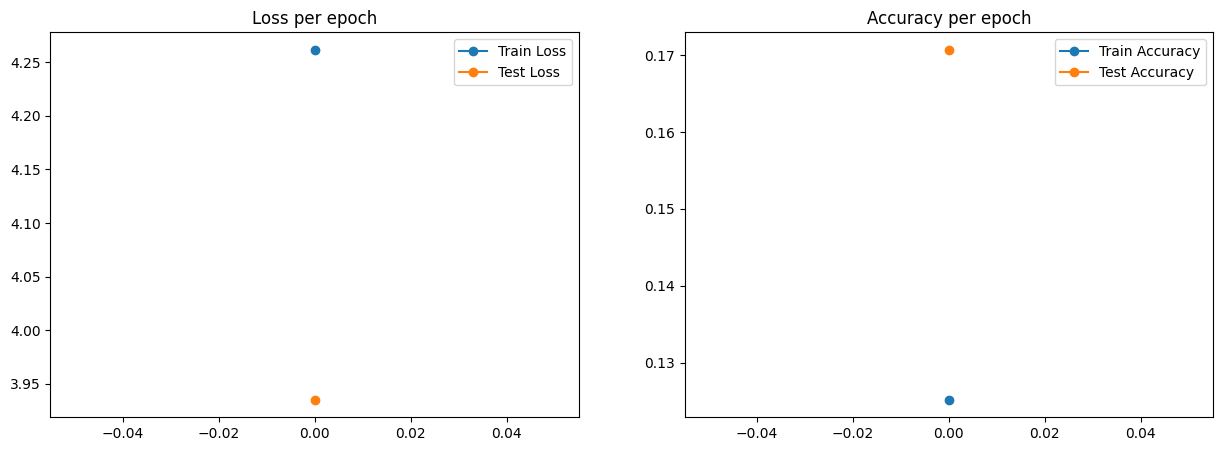

Saving best model

 		 ------------------------------ EPOCH: 2 ------------------------------
[05:25:32] Step 20/704: train loss = 3.66178
[05:25:33] Step 40/704: train loss = 3.66232
[05:25:34] Step 60/704: train loss = 3.61466
[05:25:36] Step 80/704: train loss = 3.61789
[05:25:37] Step 100/704: train loss = 3.6033
[05:25:38] Step 120/704: train loss = 3.61541
[05:25:40] Step 140/704: train loss = 3.60874
[05:25:41] Step 160/704: train loss = 3.60748
[05:25:42] Step 180/704: train loss = 3.60599
[05:25:43] Step 200/704: train loss = 3.60267
[05:25:45] Step 220/704: train loss = 3.59673
[05:25:46] Step 240/704: train loss = 3.59603
[05:25:47] Step 260/704: train loss = 3.5888
[05:25:49] Step 280/704: train loss = 3.58892
[05:25:50] Step 300/704: train loss = 3.58208
[05:25:51] Step 320/704: train loss = 3.57506
[05:25:53] Step 340/704: train loss = 3.56762
[05:25:54] Step 360/704: train loss = 3.56263
[05:25:55] Step 380/704: train loss = 3.55607
[05:25:56] Step 400/704: train loss = 

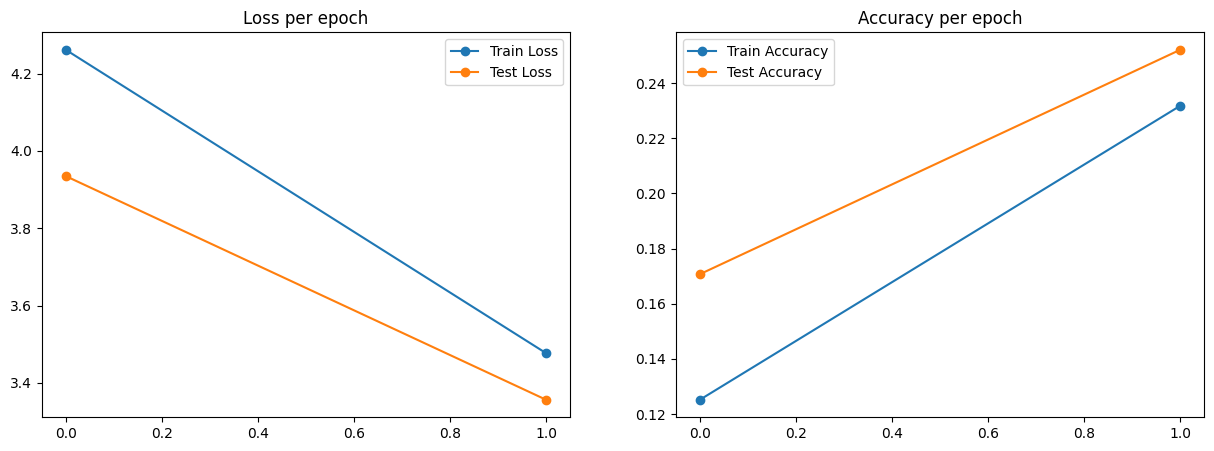

Saving best model

 		 ------------------------------ EPOCH: 3 ------------------------------
[05:26:21] Step 20/704: train loss = 3.10548
[05:26:23] Step 40/704: train loss = 3.14179
[05:26:24] Step 60/704: train loss = 3.13088
[05:26:25] Step 80/704: train loss = 3.11825
[05:26:27] Step 100/704: train loss = 3.1117
[05:26:28] Step 120/704: train loss = 3.09197
[05:26:29] Step 140/704: train loss = 3.08802
[05:26:31] Step 160/704: train loss = 3.0795
[05:26:32] Step 180/704: train loss = 3.06981
[05:26:33] Step 200/704: train loss = 3.06043
[05:26:35] Step 220/704: train loss = 3.05556
[05:26:36] Step 240/704: train loss = 3.04971
[05:26:37] Step 260/704: train loss = 3.0465
[05:26:39] Step 280/704: train loss = 3.04395
[05:26:40] Step 300/704: train loss = 3.03897
[05:26:41] Step 320/704: train loss = 3.036
[05:26:42] Step 340/704: train loss = 3.03353
[05:26:44] Step 360/704: train loss = 3.03083
[05:26:45] Step 380/704: train loss = 3.03013
[05:26:46] Step 400/704: train loss = 3.0

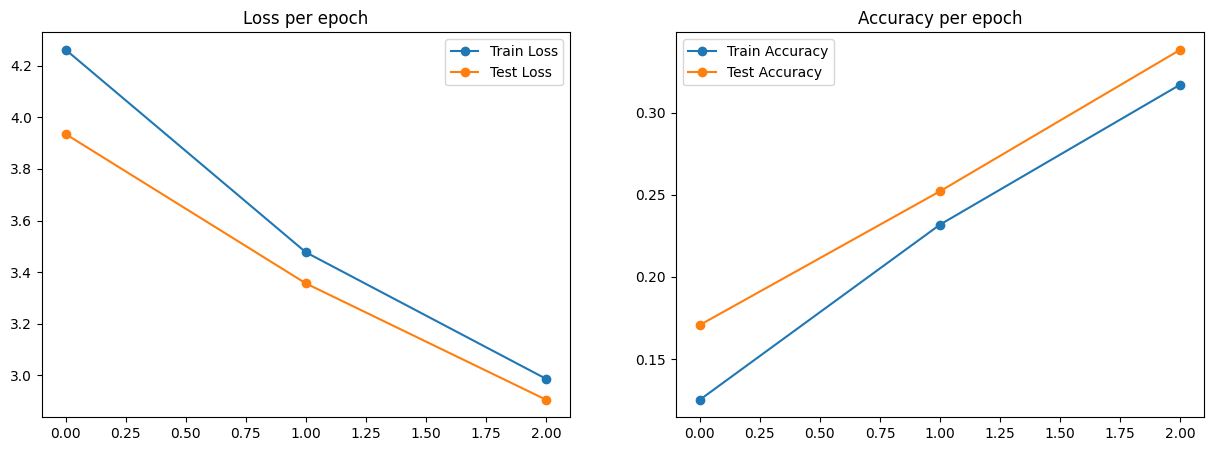

Saving best model

 		 ------------------------------ EPOCH: 4 ------------------------------
[05:27:11] Step 20/704: train loss = 2.83445
[05:27:13] Step 40/704: train loss = 2.83334
[05:27:14] Step 60/704: train loss = 2.83853
[05:27:15] Step 80/704: train loss = 2.84531
[05:27:17] Step 100/704: train loss = 2.84224
[05:27:18] Step 120/704: train loss = 2.8473
[05:27:19] Step 140/704: train loss = 2.8499
[05:27:21] Step 160/704: train loss = 2.84862
[05:27:22] Step 180/704: train loss = 2.85315
[05:27:23] Step 200/704: train loss = 2.85118
[05:27:25] Step 220/704: train loss = 2.85131
[05:27:26] Step 240/704: train loss = 2.85148
[05:27:27] Step 260/704: train loss = 2.85197
[05:27:28] Step 280/704: train loss = 2.85249
[05:27:30] Step 300/704: train loss = 2.8494
[05:27:31] Step 320/704: train loss = 2.84807
[05:27:32] Step 340/704: train loss = 2.84684
[05:27:34] Step 360/704: train loss = 2.84634
[05:27:35] Step 380/704: train loss = 2.84356
[05:27:36] Step 400/704: train loss = 2

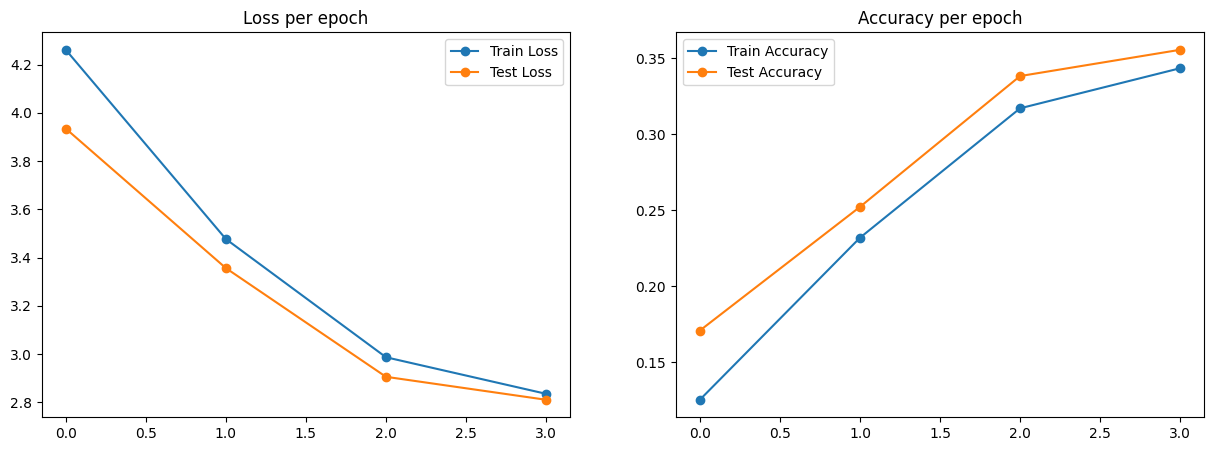

Saving best model

 		 ------------------------------ EPOCH: 5 ------------------------------
[05:28:01] Step 20/704: train loss = 2.73332
[05:28:03] Step 40/704: train loss = 2.72053
[05:28:04] Step 60/704: train loss = 2.72231
[05:28:05] Step 80/704: train loss = 2.7112
[05:28:07] Step 100/704: train loss = 2.70862
[05:28:08] Step 120/704: train loss = 2.69622
[05:28:09] Step 140/704: train loss = 2.70672
[05:28:11] Step 160/704: train loss = 2.71798
[05:28:12] Step 180/704: train loss = 2.7146
[05:28:13] Step 200/704: train loss = 2.70873
[05:28:15] Step 220/704: train loss = 2.71531
[05:28:16] Step 240/704: train loss = 2.71574
[05:28:17] Step 260/704: train loss = 2.71573
[05:28:18] Step 280/704: train loss = 2.71328
[05:28:20] Step 300/704: train loss = 2.7113
[05:28:21] Step 320/704: train loss = 2.71103
[05:28:22] Step 340/704: train loss = 2.71256
[05:28:24] Step 360/704: train loss = 2.71358
[05:28:25] Step 380/704: train loss = 2.71599
[05:28:26] Step 400/704: train loss = 2

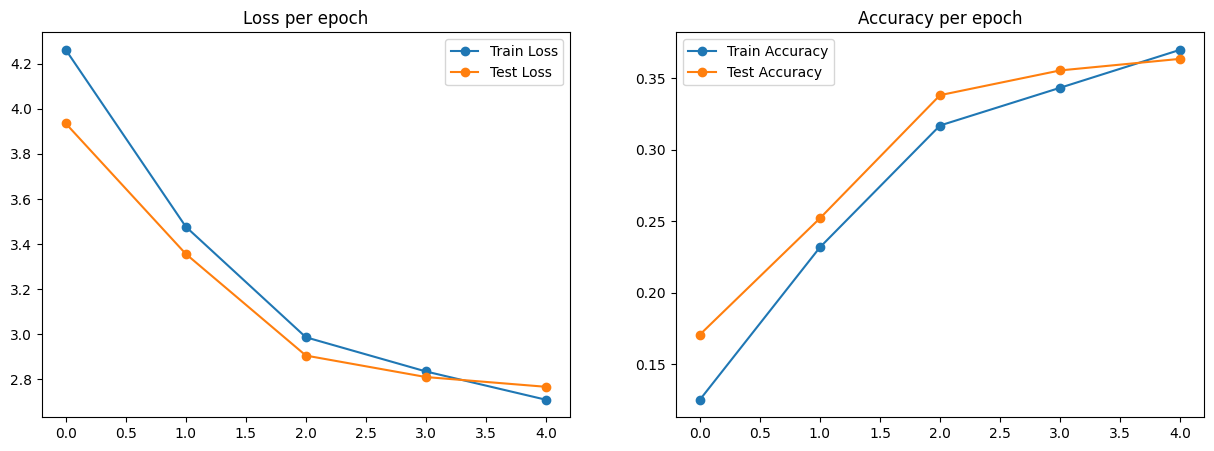

Saving best model

 		 ------------------------------ EPOCH: 6 ------------------------------
[05:28:51] Step 20/704: train loss = 2.70863
[05:28:52] Step 40/704: train loss = 2.71449
[05:28:54] Step 60/704: train loss = 2.70462
[05:28:55] Step 80/704: train loss = 2.68625
[05:28:56] Step 100/704: train loss = 2.68563
[05:28:58] Step 120/704: train loss = 2.69905
[05:28:59] Step 140/704: train loss = 2.69725
[05:29:00] Step 160/704: train loss = 2.69153
[05:29:01] Step 180/704: train loss = 2.69174
[05:29:03] Step 200/704: train loss = 2.69034
[05:29:04] Step 220/704: train loss = 2.68535
[05:29:05] Step 240/704: train loss = 2.68089
[05:29:07] Step 260/704: train loss = 2.68265
[05:29:08] Step 280/704: train loss = 2.68474
[05:29:09] Step 300/704: train loss = 2.68381
[05:29:11] Step 320/704: train loss = 2.68721
[05:29:12] Step 340/704: train loss = 2.68736
[05:29:13] Step 360/704: train loss = 2.68742
[05:29:15] Step 380/704: train loss = 2.68398
[05:29:16] Step 400/704: train loss 

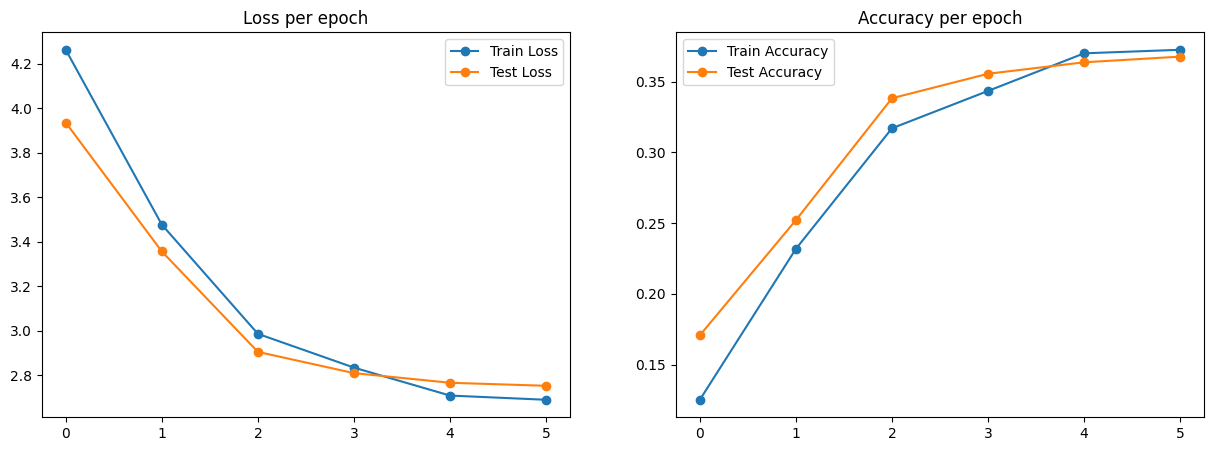

Saving best model

 		 ------------------------------ EPOCH: 7 ------------------------------
[05:29:41] Step 20/704: train loss = 2.7143
[05:29:42] Step 40/704: train loss = 2.69849
[05:29:43] Step 60/704: train loss = 2.69435
[05:29:45] Step 80/704: train loss = 2.68933
[05:29:46] Step 100/704: train loss = 2.68553
[05:29:47] Step 120/704: train loss = 2.67854
[05:29:49] Step 140/704: train loss = 2.6748
[05:29:50] Step 160/704: train loss = 2.66704
[05:29:51] Step 180/704: train loss = 2.66654
[05:29:52] Step 200/704: train loss = 2.66875
[05:29:54] Step 220/704: train loss = 2.67203
[05:29:55] Step 240/704: train loss = 2.67246
[05:29:56] Step 260/704: train loss = 2.67154
[05:29:58] Step 280/704: train loss = 2.6688
[05:29:59] Step 300/704: train loss = 2.67597
[05:30:00] Step 320/704: train loss = 2.67514
[05:30:02] Step 340/704: train loss = 2.67572
[05:30:03] Step 360/704: train loss = 2.67365
[05:30:04] Step 380/704: train loss = 2.6752
[05:30:06] Step 400/704: train loss = 2.

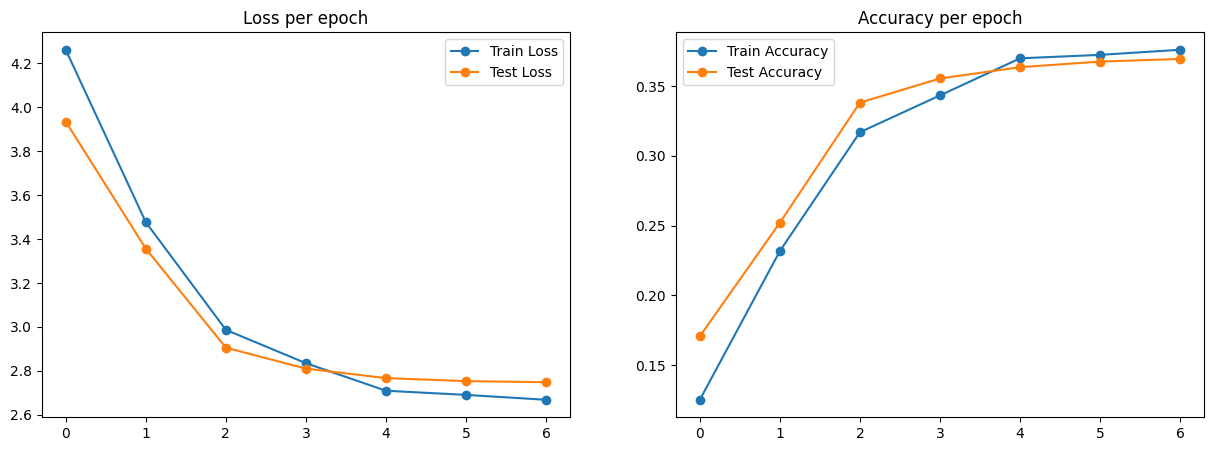

Saving best model

 		 ------------------------------ EPOCH: 8 ------------------------------
[05:30:30] Step 20/704: train loss = 2.68211
[05:30:32] Step 40/704: train loss = 2.6511
[05:30:33] Step 60/704: train loss = 2.66888
[05:30:34] Step 80/704: train loss = 2.6645
[05:30:36] Step 100/704: train loss = 2.67359
[05:30:37] Step 120/704: train loss = 2.674
[05:30:38] Step 140/704: train loss = 2.67479
[05:30:40] Step 160/704: train loss = 2.67285
[05:30:41] Step 180/704: train loss = 2.67323
[05:30:42] Step 200/704: train loss = 2.66936
[05:30:43] Step 220/704: train loss = 2.6641
[05:30:45] Step 240/704: train loss = 2.66412
[05:30:46] Step 260/704: train loss = 2.66704
[05:30:47] Step 280/704: train loss = 2.66805
[05:30:49] Step 300/704: train loss = 2.66952
[05:30:50] Step 320/704: train loss = 2.66933
[05:30:51] Step 340/704: train loss = 2.66793
[05:30:53] Step 360/704: train loss = 2.66525
[05:30:54] Step 380/704: train loss = 2.66297
[05:30:55] Step 400/704: train loss = 2.6

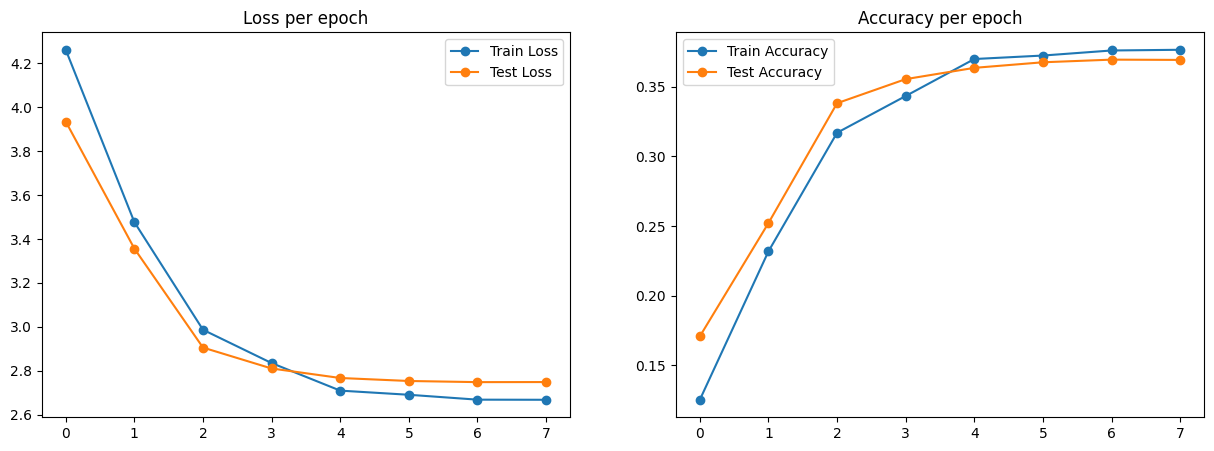

Validation loss didn't improve

 		 ------------------------------ EPOCH: 9 ------------------------------
[05:31:20] Step 20/704: train loss = 2.67852
[05:31:21] Step 40/704: train loss = 2.67263
[05:31:23] Step 60/704: train loss = 2.66214
[05:31:24] Step 80/704: train loss = 2.6557
[05:31:25] Step 100/704: train loss = 2.66423
[05:31:27] Step 120/704: train loss = 2.66132
[05:31:28] Step 140/704: train loss = 2.65224
[05:31:29] Step 160/704: train loss = 2.6488
[05:31:31] Step 180/704: train loss = 2.65427
[05:31:32] Step 200/704: train loss = 2.65066
[05:31:33] Step 220/704: train loss = 2.64855
[05:31:35] Step 240/704: train loss = 2.64798
[05:31:36] Step 260/704: train loss = 2.64833
[05:31:37] Step 280/704: train loss = 2.65345
[05:31:39] Step 300/704: train loss = 2.65251
[05:31:40] Step 320/704: train loss = 2.65533
[05:31:41] Step 340/704: train loss = 2.65654
[05:31:43] Step 360/704: train loss = 2.65531
[05:31:44] Step 380/704: train loss = 2.65854
[05:31:45] Step 400/704: 

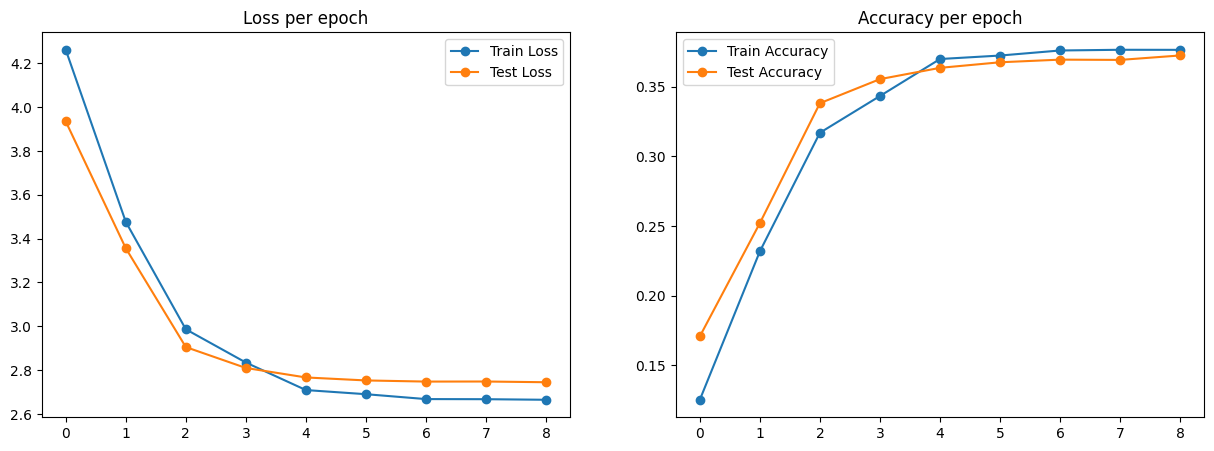

Saving best model

 		 ------------------------------ EPOCH: 10 ------------------------------
[05:32:10] Step 20/704: train loss = 2.66801
[05:32:12] Step 40/704: train loss = 2.62909
[05:32:13] Step 60/704: train loss = 2.64158
[05:32:14] Step 80/704: train loss = 2.64378
[05:32:16] Step 100/704: train loss = 2.64685
[05:32:17] Step 120/704: train loss = 2.64628
[05:32:18] Step 140/704: train loss = 2.64821
[05:32:20] Step 160/704: train loss = 2.65493
[05:32:21] Step 180/704: train loss = 2.65556
[05:32:22] Step 200/704: train loss = 2.66143
[05:32:24] Step 220/704: train loss = 2.66106
[05:32:25] Step 240/704: train loss = 2.66544
[05:32:26] Step 260/704: train loss = 2.66971
[05:32:27] Step 280/704: train loss = 2.66698
[05:32:29] Step 300/704: train loss = 2.6649
[05:32:30] Step 320/704: train loss = 2.66467
[05:32:31] Step 340/704: train loss = 2.6648
[05:32:33] Step 360/704: train loss = 2.66067
[05:32:34] Step 380/704: train loss = 2.65849
[05:32:35] Step 400/704: train loss =

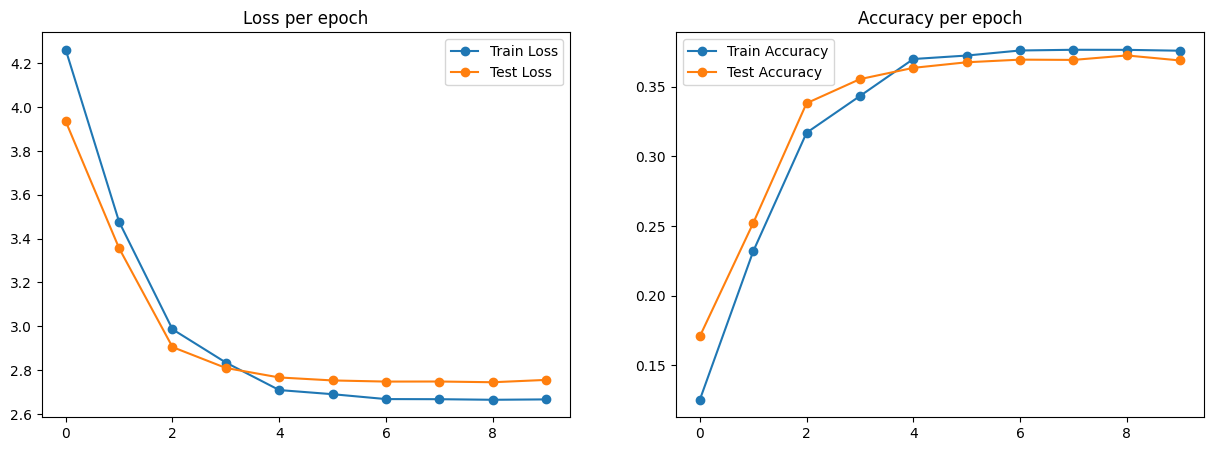

Validation loss didn't improve

 		 ------------------------------ EPOCH: 11 ------------------------------
[05:33:00] Step 20/704: train loss = 2.63673
[05:33:01] Step 40/704: train loss = 2.63766
[05:33:03] Step 60/704: train loss = 2.65171
[05:33:04] Step 80/704: train loss = 2.65419
[05:33:05] Step 100/704: train loss = 2.6571
[05:33:07] Step 120/704: train loss = 2.65668
[05:33:08] Step 140/704: train loss = 2.65683
[05:33:09] Step 160/704: train loss = 2.65331
[05:33:11] Step 180/704: train loss = 2.64762
[05:33:12] Step 200/704: train loss = 2.64659
[05:33:13] Step 220/704: train loss = 2.64102
[05:33:15] Step 240/704: train loss = 2.64141
[05:33:16] Step 260/704: train loss = 2.64201
[05:33:17] Step 280/704: train loss = 2.6489
[05:33:19] Step 300/704: train loss = 2.65061
[05:33:20] Step 320/704: train loss = 2.65404
[05:33:21] Step 340/704: train loss = 2.65522
[05:33:23] Step 360/704: train loss = 2.65695
[05:33:24] Step 380/704: train loss = 2.65968
[05:33:25] Step 400/704:

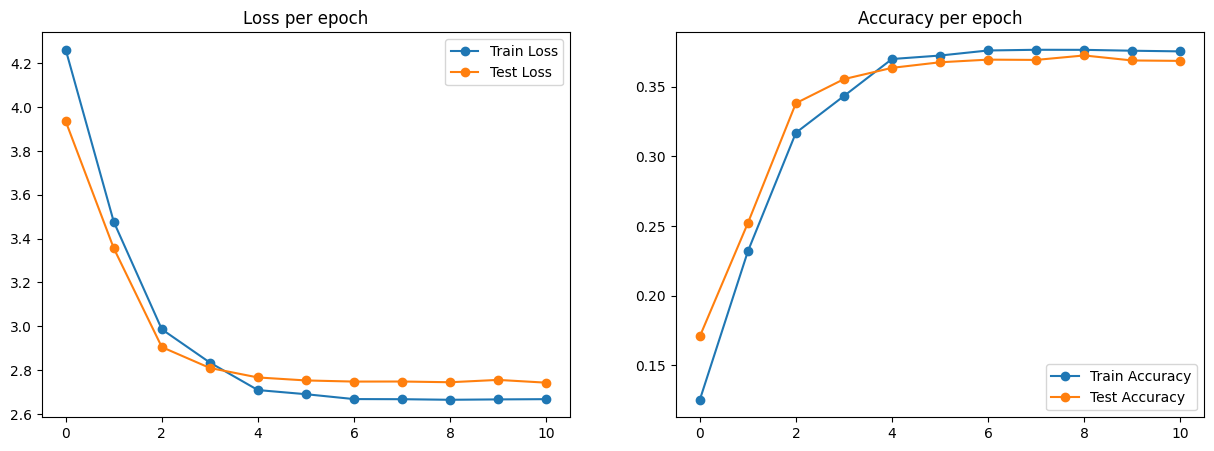

Saving best model

 		 ------------------------------ EPOCH: 12 ------------------------------
[05:33:50] Step 20/704: train loss = 2.62563
[05:33:51] Step 40/704: train loss = 2.63974
[05:33:53] Step 60/704: train loss = 2.66233
[05:33:54] Step 80/704: train loss = 2.64868
[05:33:55] Step 100/704: train loss = 2.65759
[05:33:57] Step 120/704: train loss = 2.66985
[05:33:58] Step 140/704: train loss = 2.66153
[05:33:59] Step 160/704: train loss = 2.66336
[05:34:01] Step 180/704: train loss = 2.66017
[05:34:02] Step 200/704: train loss = 2.66235
[05:34:03] Step 220/704: train loss = 2.66268
[05:34:05] Step 240/704: train loss = 2.65865
[05:34:06] Step 260/704: train loss = 2.65855
[05:34:07] Step 280/704: train loss = 2.65734
[05:34:09] Step 300/704: train loss = 2.6537
[05:34:10] Step 320/704: train loss = 2.65776
[05:34:11] Step 340/704: train loss = 2.6582
[05:34:13] Step 360/704: train loss = 2.66154
[05:34:14] Step 380/704: train loss = 2.66353
[05:34:15] Step 400/704: train loss =

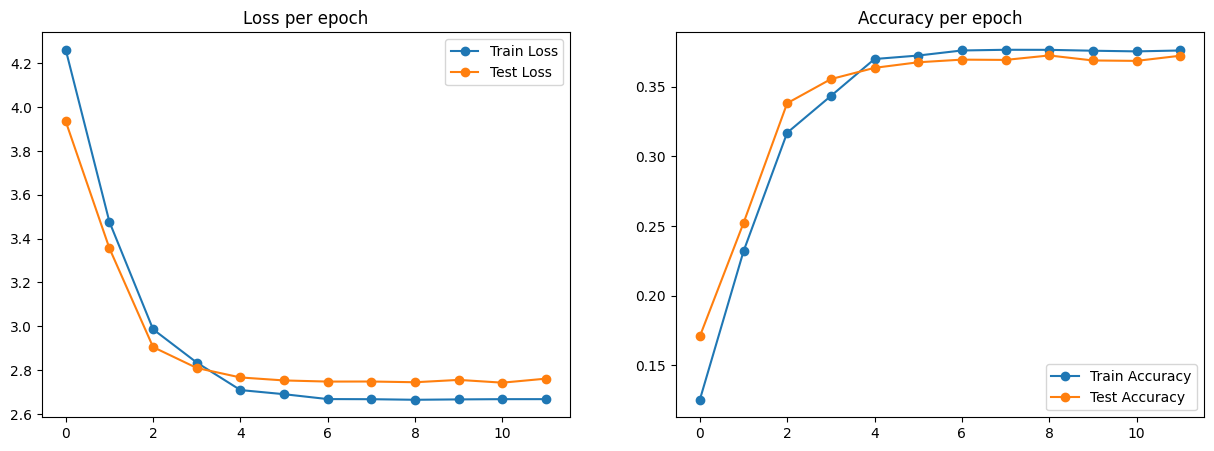

Validation loss didn't improve

 		 ------------------------------ EPOCH: 13 ------------------------------
[05:34:40] Step 20/704: train loss = 2.72796
[05:34:42] Step 40/704: train loss = 2.68891
[05:34:43] Step 60/704: train loss = 2.67308
[05:34:44] Step 80/704: train loss = 2.66838
[05:34:46] Step 100/704: train loss = 2.66946
[05:34:47] Step 120/704: train loss = 2.66372
[05:34:48] Step 140/704: train loss = 2.67379
[05:34:50] Step 160/704: train loss = 2.66835
[05:34:51] Step 180/704: train loss = 2.66679
[05:34:52] Step 200/704: train loss = 2.67057
[05:34:53] Step 220/704: train loss = 2.67359
[05:34:55] Step 240/704: train loss = 2.67169
[05:34:56] Step 260/704: train loss = 2.66753
[05:34:57] Step 280/704: train loss = 2.66922
[05:34:59] Step 300/704: train loss = 2.66648
[05:35:00] Step 320/704: train loss = 2.66927
[05:35:01] Step 340/704: train loss = 2.66919
[05:35:03] Step 360/704: train loss = 2.67011
[05:35:04] Step 380/704: train loss = 2.6693
[05:35:05] Step 400/704

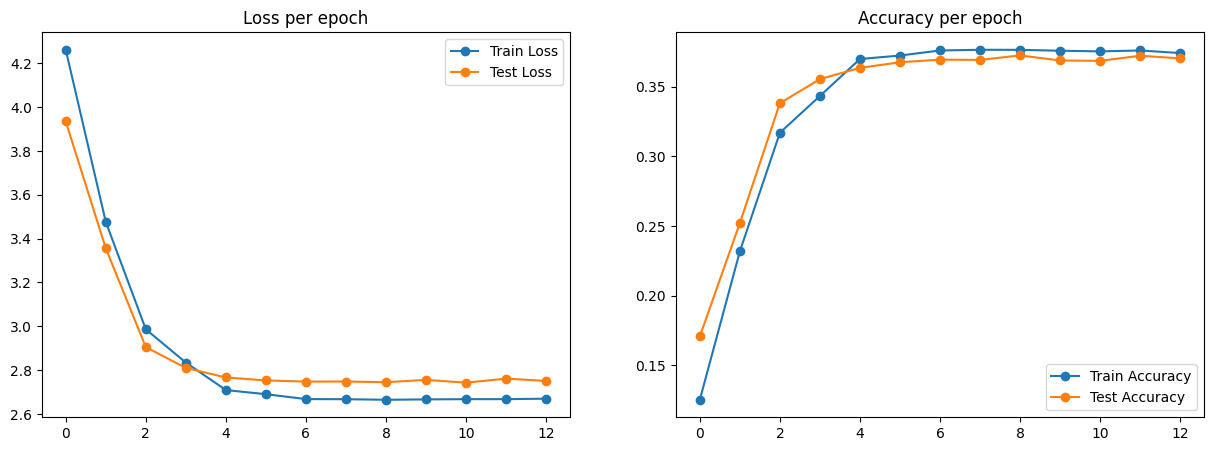

Validation loss didn't improve
EARLY STOPPING: min test_loss 2.74295, last 2 epochs min: 2.7509
Restoring the model at epoch 10: test_accuracy = 0.3686
Model successfully restored

 Training time: 10.0 minutes 48.91 seconds

 Final model is stored to model_epoch_10_test_acc_0.3686.pth


In [566]:
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    
}
t1 = monotonic()
for epoch in range(train_config['n_epochs']):
    print('\n', '\t\t', '-' * 30, f"EPOCH: {epoch + 1}", '-' * 30)

    # Train
    model.train()
    model.to(DEVICE)
    train_avg_loss, train_accuracy = do_train_epoch(model, 
                                                    criterion, 
                                                    optimizer, 
                                                    train_dataloader, 
                                                    verbose=20)

    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)

    # Val
    model.eval()
    val_avg_loss, val_accuracy = do_val_epoch(model, 
                                              criterion, 
                                              val_dataloader)
    scheduler.step()
    history['test_loss'].append(val_avg_loss)
    history['test_accuracy'].append(val_accuracy)

    # on_epoch_end events
    plot_history(history)
    
    # model checkpointing
    if history['test_loss'][-1] == min(history['test_loss']):
        print('Saving best model')
        torch.save(model.state_dict(), best_checkpoint_path)
    else:
        print("Validation loss didn't improve")

    # early stopping
    if min(history['test_loss'][-2:]) > min(history['test_loss']):
        best_epoch = np.argmin(history['test_loss'])
        best_test_accuracy = history['test_accuracy'][best_epoch]

        print(f'EARLY STOPPING: min test_loss {min(history["test_loss"])}, last 2 epochs min: {min(history["test_loss"][-2:])}')
        print(f'Restoring the model at epoch {best_epoch}: test_accuracy = {best_test_accuracy}')

        model.load_state_dict(torch.load(best_checkpoint_path, weights_only=True))
        print('Model successfully restored')
        break
t2 = monotonic()
m, s = divmod(t2 - t1, 60)
    # lr_adjustments (todo)


# saving the best model to hard storage
model_file_name = f'model_epoch_{best_epoch}_test_acc_{best_test_accuracy}.pth'
torch.save(model.state_dict(), f'../working/{model_file_name}')

print(f'\n Training time: {m} minutes {round(s, 2)} seconds')
print(f'\n Final model is stored to {model_file_name}')
os.remove(best_checkpoint_path)

### Make a prediction and prepare submission file

In [567]:
import pandas as pd

In [568]:
class TestDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 file_names: list[str],
                 transform=None):
        self.img_dir = img_dir
        self.file_names = file_names
        self.image_ids = [int(n.split('.')[0].split('_')[1]) for n in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        img_id = self.image_ids[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [569]:
test_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/val'
test_image_names = sorted(os.listdir(f'{test_folder}/images'))
len(test_image_names)

10000

In [570]:
test_dataset = TestDataset(f'{test_folder}/images', test_image_names, transform=val_img_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [571]:
model.eval()

test_predictions = pd.Series([-1] * len(test_dataset))

total_steps = len(test_dataloader)
step = 0

with torch.no_grad():
    for X, img_ids in test_dataloader:
        preds = model(X.to(DEVICE)).cpu()
        
        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # predicted_labels = torch.tensor([0] * X.shape[0])

        test_predictions.loc[img_ids] = predicted_labels.numpy()
        step += 1

        if step % 10 == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps} done")

[05:35:29] Step 10/79 done
[05:35:30] Step 20/79 done
[05:35:30] Step 30/79 done
[05:35:31] Step 40/79 done
[05:35:31] Step 50/79 done
[05:35:32] Step 60/79 done
[05:35:32] Step 70/79 done


In [572]:
test_predictions_df = (test_predictions
                       .reset_index()
                       .rename(columns={'index': 'ID', 0: 'class'}))
test_predictions_df.head()

,ID,class
0,0,62
1,1,110
2,2,66
3,3,14
4,4,139


In [573]:
# here we will do some analysis to ensure predictions file looks reasonable
(test_predictions_df['class'] < 0).sum()

np.int64(0)

In [574]:
test_predictions_df['class'].value_counts()

class
107    102
123     95
132     93
121     90
165     90
      ... 
127     10
166      6
106      4
118      3
164      3
Name: count, Length: 200, dtype: int64

In [575]:
test_predictions_df['class'] = test_predictions_df['class'].map(class_id_to_name_dict)
test_predictions_df['ID'] = test_predictions_df['ID'].apply(lambda v: f'val_{v}.JPEG')

In [576]:
test_predictions_df.head()

,ID,class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n01698640
2,val_2.JPEG,n03014705
3,val_3.JPEG,n03179701
4,val_4.JPEG,n03770439


In [577]:
test_predictions_df.to_csv(f'../working/submission_{model_file_name}.csv', index=False)